## This dataset comes from Kaggle - https://www.kaggle.com/dalpozz/creditcardfraud
## This tutorial demonstrates how to use unsupervised training for fraud detection. The main model implemented here is auto-encoder, which achives 0.95 of AUC on test set. 
### Author: Weimin Wang
### Date: June 18, 2017

## Load libraries 

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from datetime import datetime 
from sklearn.metrics import roc_auc_score as auc 
import seaborn as sns

In [4]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

## Data Exploration

In [58]:
data_dir = "C:\\Users\\weimin\\Desktop\\Fraud"
df = pd.read_csv(os.path.join(data_dir, 'creditcard.csv'))

In [59]:
df.shape

(284807, 31)

In [60]:
print("Total time spanning: {:.1f} days".format(df['Time'].max() / (3600 * 24.0)))
print("{:.3f} % of all transactions are fraud. ".format(np.sum(df['Class']) / df.shape[0] * 100))

Total time spanning: 2.0 days
0.173 % of all transactions are fraud. 


In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [63]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [64]:
df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

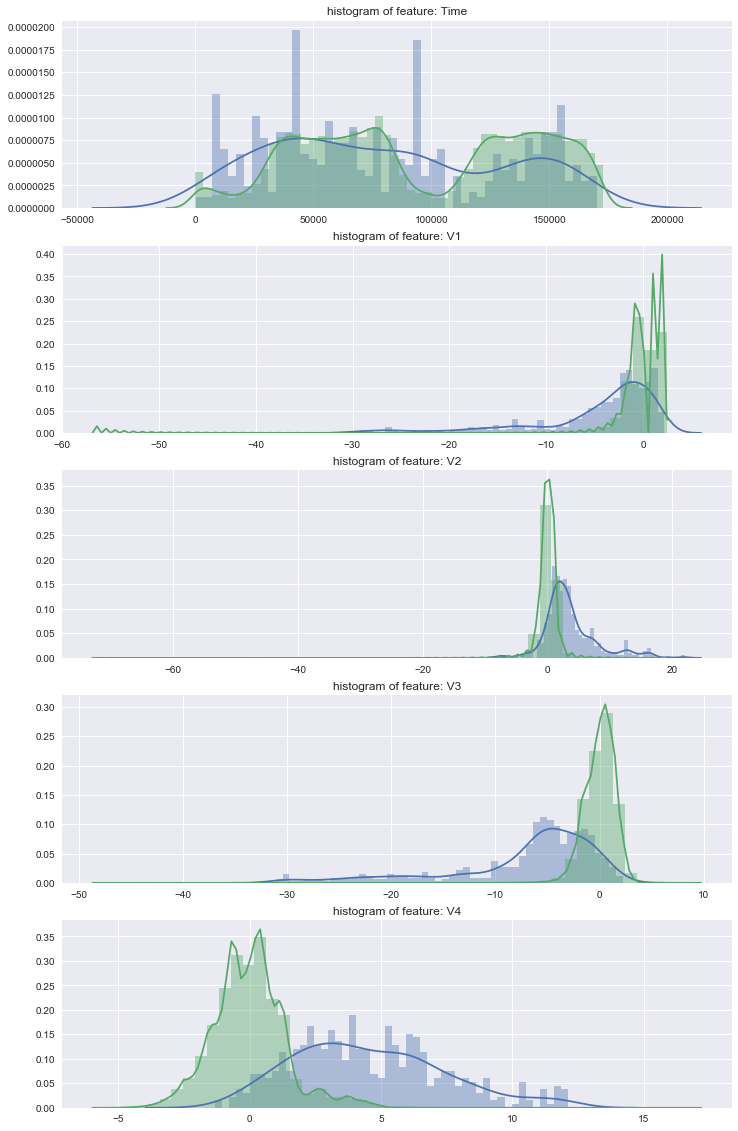

In [65]:
plt.figure(figsize=(12,5*4))
gs = gridspec.GridSpec(5, 1)
for i, cn in enumerate(df.columns[:5]):
    ax = plt.subplot(gs[i])
    sns.distplot(df[cn][df.Class == 1], bins=50)
    sns.distplot(df[cn][df.Class == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()

## Train and test split on time series, using first 75% as training/val, and last 25% as test

In [9]:
TEST_RATIO = 0.25
df.sort_values('Time', inplace = True)
TRA_INDEX = int((1-TEST_RATIO) * df.shape[0])
train_x = df.iloc[:TRA_INDEX, 1:-2].values
train_y = df.iloc[:TRA_INDEX, -1].values

test_x = df.iloc[TRA_INDEX:, 1:-2].values
test_y = df.iloc[TRA_INDEX:, -1].values

In [6]:
print("Total train examples: {}, total fraud cases: {}, equal to {:.5f} of total cases. ".format(train_x.shape[0], np.sum(train_y), np.sum(train_y)/train_x.shape[0]))

Total train examples: 213605, total fraud cases: 398, equal to 0.00186 of total cases. 


In [7]:
print("Total test examples: {}, total fraud cases: {}, equal to {:.5f} of total cases. ".format(test_x.shape[0], np.sum(test_y), np.sum(test_y)/test_y.shape[0]))

Total test examples: 71202, total fraud cases: 94, equal to 0.00132 of total cases. 


## Feature Normalization - min max score (used for sigmoid activation)

In [10]:
'''cols_max = []
cols_min = []
for c in range(train_x.shape[1]):
    cols_max.append(train_x[:,c].max())
    cols_min.append(train_x[:,c].min())
    train_x[:, c] = (train_x[:, c] - cols_min[-1]) / (cols_max[-1] - cols_min[-1])
    test_x[:, c] =  (test_x[:, c] - cols_min[-1]) / (cols_max[-1] - cols_min[-1])'''

## Feature Normalization 2 - z score (for tanh activation)

In [10]:
cols_mean = []
cols_std = []
for c in range(train_x.shape[1]):
    cols_mean.append(train_x[:,c].mean())
    cols_std.append(train_x[:,c].std())
    train_x[:, c] = (train_x[:, c] - cols_mean[-1]) / cols_std[-1]
    test_x[:, c] =  (test_x[:, c] - cols_mean[-1]) / cols_std[-1]

## Modelling and results


## 1. Auto-encoder as unsupervised learning

### Parameters

In [11]:
# Parameters
learning_rate = 0.01
training_epochs = 10
batch_size = 256
display_step = 1

# Network Parameters
n_hidden_1 = 15 # 1st layer num features
#n_hidden_2 = 15 # 2nd layer num features
n_input = train_x.shape[1] # MNIST data input (img shape: 28*28)

### Train and val the model - (1 hidden layer turned out to be enough)

In [12]:
X = tf.placeholder("float", [None, n_input])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    #'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
    #'decoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    #'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([n_input])),
    #'decoder_b2': tf.Variable(tf.random_normal([n_input])),
}


# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.tanh(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    #layer_2 = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   #biases['encoder_b2']))
    return layer_1


# Building the decoder
def decoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.tanh(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    #layer_2 = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                  # biases['decoder_b2']))
    return layer_1

# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define batch mse
batch_mse = tf.reduce_mean(tf.pow(y_true - y_pred, 2), 1)

# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

# TRAIN StARTS
save_model = os.path.join(data_dir, 'temp_saved_model_1layer.ckpt')
saver = tf.train.Saver()

# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    now = datetime.now()
    sess.run(init)
    total_batch = int(train_x.shape[0]/batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_idx = np.random.choice(train_x.shape[0], batch_size)
            batch_xs = train_x[batch_idx]
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
            
        # Display logs per epoch step
        if epoch % display_step == 0:
            train_batch_mse = sess.run(batch_mse, feed_dict={X: train_x})
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c), 
                  "Train auc=", "{:.6f}".format(auc(train_y, train_batch_mse)), 
                  "Time elapsed=", "{}".format(datetime.now() - now))

    print("Optimization Finished!")
    
    save_path = saver.save(sess, save_model)
    print("Model saved in file: %s" % save_path)
    

Epoch: 0001 cost= 0.411727011 Train auc= 0.956021 Time elapsed= 0:00:01.806808
Epoch: 0002 cost= 0.846064389 Train auc= 0.953359 Time elapsed= 0:00:03.255659
Epoch: 0003 cost= 0.354484618 Train auc= 0.953008 Time elapsed= 0:00:04.644354
Epoch: 0004 cost= 0.521521986 Train auc= 0.953450 Time elapsed= 0:00:06.098230
Epoch: 0005 cost= 0.517319083 Train auc= 0.953781 Time elapsed= 0:00:07.534039
Epoch: 0006 cost= 0.679800570 Train auc= 0.954154 Time elapsed= 0:00:08.928748
Epoch: 0007 cost= 0.325362355 Train auc= 0.953365 Time elapsed= 0:00:10.329510
Epoch: 0008 cost= 0.411871493 Train auc= 0.953527 Time elapsed= 0:00:11.756268
Epoch: 0009 cost= 0.280223519 Train auc= 0.954088 Time elapsed= 0:00:13.173037
Epoch: 0010 cost= 1.056191683 Train auc= 0.953535 Time elapsed= 0:00:14.504578
Optimization Finished!
Model saved in file: C:\Users\weimin\Desktop\Fraud\temp_saved_model_1layer.ckpt


### Test model - on later 25% test data

In [13]:
save_model = os.path.join(data_dir, 'temp_saved_model_1layer.ckpt')
saver = tf.train.Saver()

# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    now = datetime.now()
    
    saver.restore(sess, save_model)
    
    test_batch_mse = sess.run(batch_mse, feed_dict={X: test_x})
    
    print("Test auc score: {:.6f}".format(auc(test_y, test_batch_mse)))
    

INFO:tensorflow:Restoring parameters from C:\Users\weimin\Desktop\Fraud\temp_saved_model_1layer.ckpt
Test auc score: 0.943175


## Visualize the prediction

### 1. Show distribution of all mse (fraud scores if you want to call it)

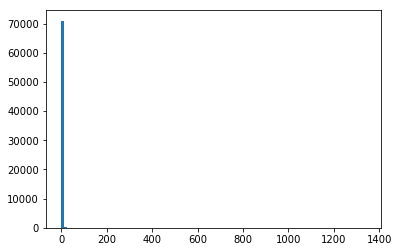

In [24]:
plt.hist(test_batch_mse, bins = 100)
plt.show()

### Zoom into (0, 20) range

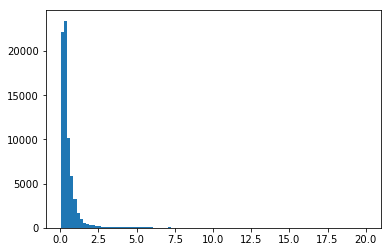

In [26]:
plt.hist(test_batch_mse[test_batch_mse < 20], bins = 100)
plt.show()

### 2. Display only fraud cases

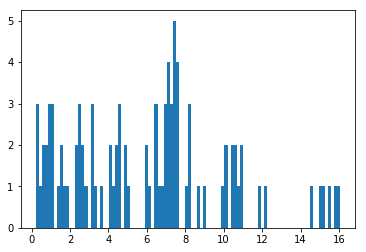

In [35]:
plt.hist(test_batch_mse[test_y == 1.0], bins = 100)
plt.show()

In [34]:
THRE_TEST = 7
print(" All scores above treshold: {}, all pos above threshold: {}, and percentage of accuracy above treshold are: {}".format( \
        np.sum(test_y[test_batch_mse > THRE_TEST]), np.sum(test_batch_mse > THRE_TEST), np.sum(test_y[test_batch_mse > THRE_TEST]) / np.sum(test_batch_mse > THRE_TEST)))
      

 All scores above treshold: 41, all pos above threshold: 561, and percentage of accuracy above treshold are: 0.07308377896613191


## 2. Build a binary classifier that output probabilities of being fraud, using encoded layer insider auto-encoder as model input 

### 1) Get auto-encoder embedding (encoder_op) for both train and test data

In [16]:
save_model = os.path.join(data_dir, 'temp_saved_model_1layer.ckpt')
saver = tf.train.Saver()

# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    now = datetime.now()
    saver.restore(sess, save_model)
    
    test_encoding = sess.run(encoder_op, feed_dict={X: test_x})
    train_encoding = sess.run(encoder_op, feed_dict={X: train_x})
    
    print("Dim for test_encoding and train_encoding are: \n", test_encoding.shape, '\n', train_encoding.shape)

INFO:tensorflow:Restoring parameters from C:\Users\weimin\Desktop\Fraud\temp_saved_model_1layer.ckpt
Dim for test_encoding and train_encoding are: 
 (71202, 15) 
 (213605, 15)


### 2) Build the graph to for FC layers (choosing number of hidden neurals using validation set)

In [34]:
#n_input = test_encoding.shape[1]
n_input = test_encoding.shape[1]

hidden_size = 4
output_size = 2

X = tf.placeholder(tf.float32, [None, n_input], name='input_x')
y_ = tf.placeholder(tf.int32, shape=[None, output_size], name='target_y')

weights = {
    'W1': tf.Variable(tf.truncated_normal([n_input, hidden_size])),
    'W2': tf.Variable(tf.truncated_normal([hidden_size, output_size])),
}
biases = {
    'b1': tf.Variable(tf.zeros([hidden_size])),
    'b2': tf.Variable(tf.zeros([output_size])),
}

hidden_layer =  tf.nn.relu(tf.add(tf.matmul(X, weights['W1']), biases['b1']))
pred_logits = tf.add(tf.matmul(hidden_layer, weights['W2']), biases['b2'])
pred_probs = tf.nn.softmax(pred_logits)

cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=pred_logits))

optimizer = tf.train.AdamOptimizer(2e-4).minimize(cross_entropy)


### 3) Prepare the data set (train : val : test = (0.75 x 0.8 : 0.75 x 0.2 : 0.25 x 1.0)), and train the model

In [38]:
n_epochs = 70
batch_size = 256

# PREPARE DATA
VAL_PERC = 0.2
all_y_bin = np.zeros((df.shape[0], 2))
all_y_bin[range(df.shape[0]), df['Class'].values] = 1

train_enc_x = train_encoding[:int(train_encoding.shape[0] * (1-VAL_PERC))]
train_enc_y = all_y_bin[:int(train_encoding.shape[0] * (1-VAL_PERC))]

val_enc_x = train_encoding[int(train_encoding.shape[0] * (1-VAL_PERC)):]
val_enc_y = all_y_bin[int(train_encoding.shape[0] * (1-VAL_PERC)):train_encoding.shape[0]]

test_enc_y = all_y_bin[train_encoding.shape[0]:]
print("Num of data for train, val and test are: \n{}, \n{}, \n{}".format(train_enc_x.shape[0], val_enc_x.shape[0], \
                                                                        test_encoding.shape[0]))

# TRAIN STARTS
save_model = os.path.join(data_dir, 'temp_saved_model_FCLayers.ckpt')
saver = tf.train.Saver()

# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    now = datetime.now()
    sess.run(init)
    total_batch = int(train_enc_x.shape[0]/batch_size)
    # Training cycle
    for epoch in range(n_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_idx = np.random.choice(train_enc_x.shape[0], batch_size)
            batch_xs = train_enc_x[batch_idx]
            batch_ys = train_enc_y[batch_idx]

            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cross_entropy], feed_dict={X: batch_xs, y_: batch_ys})
            
        # Display logs per epoch step
        if epoch % display_step == 0:
            val_probs = sess.run(pred_probs, feed_dict={X: val_enc_x})
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c), 
                  "Val auc=", "{:.6f}".format(auc(val_enc_y[:, 1], val_probs[:, 1])), 
                  "Time elapsed=", "{}".format(datetime.now() - now))

    print("Optimization Finished!")
    
    save_path = saver.save(sess, save_model)
    print("Model saved in file: %s" % save_path)
    

Num of data for train, val and test are: 
170884, 
42721, 
71202
Epoch: 0001 cost= 0.182581738 Val auc= 0.207731 Time elapsed= 0:00:03.417090
Epoch: 0002 cost= 0.058460854 Val auc= 0.213936 Time elapsed= 0:00:03.948501
Epoch: 0003 cost= 0.030899705 Val auc= 0.236756 Time elapsed= 0:00:04.469928
Epoch: 0004 cost= 0.052337252 Val auc= 0.399662 Time elapsed= 0:00:04.997292
Epoch: 0005 cost= 0.012877962 Val auc= 0.747521 Time elapsed= 0:00:05.495617
Epoch: 0006 cost= 0.036469478 Val auc= 0.895387 Time elapsed= 0:00:06.020049
Epoch: 0007 cost= 0.016839981 Val auc= 0.921843 Time elapsed= 0:00:06.534381
Epoch: 0008 cost= 0.045645520 Val auc= 0.931608 Time elapsed= 0:00:07.066796
Epoch: 0009 cost= 0.001679820 Val auc= 0.935035 Time elapsed= 0:00:07.579160
Epoch: 0010 cost= 0.007926022 Val auc= 0.936375 Time elapsed= 0:00:08.127619
Epoch: 0011 cost= 0.003439063 Val auc= 0.937361 Time elapsed= 0:00:08.654019
Epoch: 0012 cost= 0.006417141 Val auc= 0.937514 Time elapsed= 0:00:09.185460
Epoch: 0013

### 4) Test the model on test data - improved on AUC slightly 

In [39]:
save_model = os.path.join(data_dir, 'temp_saved_model_FCLayers.ckpt')
saver = tf.train.Saver()
# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    now = datetime.now()
    
    saver.restore(sess, save_model)
    
    test_probs = sess.run(pred_probs, feed_dict={X: test_encoding})
    
    print("Test auc score: {}".format(auc(test_enc_y[:, 1], test_probs[:, 1])))

INFO:tensorflow:Restoring parameters from C:\Users\weimin\Desktop\Fraud\temp_saved_model_FCLayers.ckpt
Test auc score: 0.9556314697810582


## 3. (Optional) However, let's test a simple supervisied neural network (two layers) from scratch - without auto-encoder

### 1) Build graph - 15 (input) -> 10 -> 5 -> 2

In [44]:
n_epochs = 200
batch_size = 256

#n_input = test_encoding.shape[1]
n_input = train_x.shape[1]

hidden1_size = 8
hidden2_size = 4
output_size = 2

X = tf.placeholder(tf.float32, [None, n_input], name='input_x')
y_ = tf.placeholder(tf.int32, shape=[None, output_size], name='target_y')

weights = {
    'W1': tf.Variable(tf.truncated_normal([n_input, hidden1_size])),
    'W2': tf.Variable(tf.truncated_normal([hidden1_size, hidden2_size])),
    'W3': tf.Variable(tf.truncated_normal([hidden2_size, output_size])),
}
biases = {
    'b1': tf.Variable(tf.zeros([hidden1_size])),
    'b2': tf.Variable(tf.zeros([hidden2_size])),
    'b3': tf.Variable(tf.zeros([output_size])),
}

hidden1_layer =  tf.nn.relu(tf.add(tf.matmul(X, weights['W1']), biases['b1']))
hidden2_layer =  tf.nn.relu(tf.add(tf.matmul(hidden1_layer, weights['W2']), biases['b2']))
pred_logits = tf.add(tf.matmul(hidden2_layer, weights['W3']), biases['b3'])
pred_probs = tf.nn.softmax(pred_logits)

cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=pred_logits))

optimizer = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)


### 2) Prepare the data (train : val : test = (0.75 x 0.8 : 0.75 x 0.2 : 0.25 x 1.0) ), and train the network

In [45]:
# PREPARE DATA
VAL_PERC = 0.2
all_y_bin = np.zeros((df.shape[0], 2))
all_y_bin[range(df.shape[0]), df['Class'].values] = 1

train_enc_x = train_x[:int(train_x.shape[0] * (1-VAL_PERC))]
train_enc_y = all_y_bin[:int(train_x.shape[0] * (1-VAL_PERC))]

val_enc_x = train_x[int(train_encoding.shape[0] *  (1-VAL_PERC)):]
val_enc_y = all_y_bin[int(train_encoding.shape[0] * (1-VAL_PERC)):train_x.shape[0]]

test_enc_y = all_y_bin[train_x.shape[0]:]

print("Num of data for train, val and test are: \n{}, \n{}, \n{}".format(train_enc_x.shape[0], val_enc_x.shape[0], \
                                                                        test_encoding.shape[0]))
# TRAIN STARTS
save_model = os.path.join(data_dir, 'temp_saved_model_FCNNets_raw.ckpt')
saver = tf.train.Saver()

# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    now = datetime.now()
    sess.run(init)
    total_batch = int(train_enc_x.shape[0]/batch_size)
    # Training cycle
    for epoch in range(n_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_idx = np.random.choice(train_enc_x.shape[0], batch_size)
            batch_xs = train_enc_x[batch_idx]
            batch_ys = train_enc_y[batch_idx]
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cross_entropy], feed_dict={X: batch_xs, y_: batch_ys})
            
        # Display logs per epoch step
        if epoch % display_step == 0:
            val_probs = sess.run(pred_probs, feed_dict={X: val_enc_x})
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c), 
                  "Val auc=", "{:.6f}".format(auc(val_enc_y[:, 1], val_probs[:, 1])), 
                  "Time elapsed=", "{}".format(datetime.now() - now))

    print("Optimization Finished!")
    
    save_path = saver.save(sess, save_model)
    print("Model saved in file: %s" % save_path)
    

Num of data for train, val and test are: 
170884, 
42721, 
71202
Epoch: 0001 cost= 0.040468249 Val auc= 0.325239 Time elapsed= 0:00:05.180817
Epoch: 0002 cost= 0.035306405 Val auc= 0.388354 Time elapsed= 0:00:05.851594
Epoch: 0003 cost= 0.035373054 Val auc= 0.467323 Time elapsed= 0:00:06.498285
Epoch: 0004 cost= 0.058311760 Val auc= 0.532444 Time elapsed= 0:00:07.163055
Epoch: 0005 cost= 0.019052731 Val auc= 0.593557 Time elapsed= 0:00:07.815824
Epoch: 0006 cost= 0.044786640 Val auc= 0.645813 Time elapsed= 0:00:08.532697
Epoch: 0007 cost= 0.018334387 Val auc= 0.701125 Time elapsed= 0:00:09.236605
Epoch: 0008 cost= 0.014931509 Val auc= 0.769009 Time elapsed= 0:00:09.936430
Epoch: 0009 cost= 0.011636144 Val auc= 0.810144 Time elapsed= 0:00:10.559088
Epoch: 0010 cost= 0.008489504 Val auc= 0.832298 Time elapsed= 0:00:11.160689
Epoch: 0011 cost= 0.006762304 Val auc= 0.843969 Time elapsed= 0:00:11.762322
Epoch: 0012 cost= 0.007114011 Val auc= 0.851879 Time elapsed= 0:00:12.370904
Epoch: 0013

Epoch: 0107 cost= 0.000196609 Val auc= 0.942604 Time elapsed= 0:01:12.383848
Epoch: 0108 cost= 0.000243780 Val auc= 0.943162 Time elapsed= 0:01:13.077695
Epoch: 0109 cost= 0.014628510 Val auc= 0.943442 Time elapsed= 0:01:13.694372
Epoch: 0110 cost= 0.003521365 Val auc= 0.943230 Time elapsed= 0:01:14.289953
Epoch: 0111 cost= 0.001652211 Val auc= 0.943194 Time elapsed= 0:01:14.983799
Epoch: 0112 cost= 0.000318703 Val auc= 0.943722 Time elapsed= 0:01:15.605455
Epoch: 0113 cost= 0.006262233 Val auc= 0.944066 Time elapsed= 0:01:16.206014
Epoch: 0114 cost= 0.000739925 Val auc= 0.944397 Time elapsed= 0:01:16.824659
Epoch: 0115 cost= 0.005477867 Val auc= 0.944826 Time elapsed= 0:01:17.430272
Epoch: 0116 cost= 0.000283423 Val auc= 0.944952 Time elapsed= 0:01:18.041897
Epoch: 0117 cost= 0.000238850 Val auc= 0.944982 Time elapsed= 0:01:18.637517
Epoch: 0118 cost= 0.000245154 Val auc= 0.945127 Time elapsed= 0:01:19.248141
Epoch: 0119 cost= 0.002327343 Val auc= 0.945271 Time elapsed= 0:01:19.850708

### 3) Predict on test data

In [47]:
save_model = os.path.join(data_dir, 'temp_saved_model_FCNNets_raw.ckpt')
saver = tf.train.Saver()
# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    now = datetime.now()
    
    saver.restore(sess, save_model)
    
    test_probs = sess.run(pred_probs, feed_dict={X: test_x})
    
    print("Test auc score: {}".format(auc(test_enc_y[:, 1], test_probs[:, 1])))

INFO:tensorflow:Restoring parameters from C:\Users\weimin\Desktop\Fraud\temp_saved_model_FCNNets_raw.ckpt
Test auc score: 0.9480815965884679
